<b>Scratch Pad</b>  
User interaction data (ie # of comments, per subreddit etc)

In [3]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ggplot import *
import networkx as nx
from networkx.readwrite import json_graph
from operator import itemgetter
from collections import Counter
from bs4 import BeautifulSoup
%matplotlib inline
os.chdir("C:/Users/macle/Desktop/UPC Masters/Semester 2/CI/Final Project")

In [2]:
with open('reddit_data.json','r') as data_file:    
    reddit_data = json.load(data_file)

In [3]:
df = pd.DataFrame(reddit_data,columns=['user','subreddit','submission','utc_stamp','rnd_words'])
df.head()

,user,subreddit,submission,utc_stamp,rnd_words
0,popesnutsack,worldpolitics,[102 million dead California trees 'unpreceden...,1.479652e+09,"[water, If, one, tree]"
1,popesnutsack,Offensive_Wallpapers,[Ya gotta love PornHub comments [2400 x 1350]],1.479651e+09,"[My, next, alimoni, payment]"
2,popesnutsack,funny,"[""Oh my fucking god!""]",1.479650e+09,"[Now, hard, on]"
3,popesnutsack,ImGoingToHellForThis,[First Day in Office],1.479518e+09,"[Can, hope, cheeto, board]"
4,popesnutsack,mildlyinteresting,[We do Not hire LIBERALS. Rude sign in conveni...,1.479513e+09,"[Veri, eloqu, craft, wordsmith]"


<h2>Dataset Size</h2>

In [10]:
print("Unique Users = " + str(len(df.groupby('user')['user'].nunique())))
print("Unique Subreddits = " + str(len(df.groupby('subreddit')['subreddit'].nunique())))
print("Unique Submissions = " + str(len(df.groupby(['user','subreddit'])['submission'].nunique())))
df.shape

Unique Users = 1220
Unique Subreddits = 9869
Unique Submissions = 72247


(753625, 5)

<h2>Subreddit Data</h2>

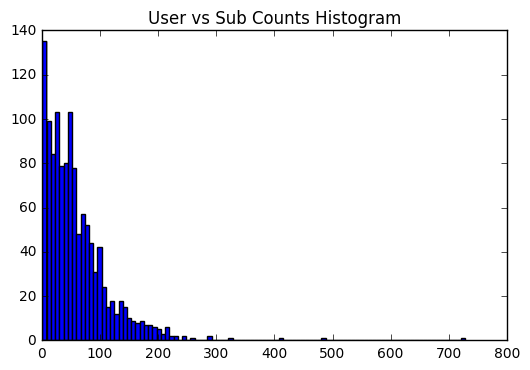

In [11]:
user_subs = df.groupby(['user'])['subreddit'].nunique()
plt.hist(user_subs.values, bins=100)
plt.title("User vs Sub Counts Histogram")
plt.show()

In [11]:
sub_users = df.groupby(['subreddit'])['user'].nunique()
data_tuple = pd.DataFrame([(sub,count) for sub,count in sub_users.items()],columns=["sub","user_count"])
sorted_df = data_tuple.sort_values(by='user_count',ascending=False)
sorted_df.head(50)

,sub,user_count
411,AskReddit,943
8258,pics,763
6703,funny,748
9349,todayilearned,695
9591,videos,651
6821,gifs,650
6753,gaming,632
9772,worldnews,599
7951,news,563
4092,Showerthoughts,541


<h2>Network Data</h2>

In [4]:
def MakeList(x):
    T = tuple(x)
    if len(T) > 1:
        return T
    else:
        return T[0]
f = {'subreddit':['count'], 'utc_stamp':[np.min,np.max],'submission': MakeList,'rnd_words': MakeList}
grouped = df.groupby(['user','subreddit']).agg(f)

In [8]:
grouped.head()

rnd_words  \
                                                                    MakeList   
user   subreddit                                                               
-DEAD- 1200isplenty                               [Im, pikelet, call, Where]   
       ANormalDayInRussia           ([look, Someth, me, fake], [Look, fake])   
       Bonsai              ([it, see, make, Ill, I], [AKL], [know, Next, ...   
       Catan               [therefor, consequ, move, transfer, therefor, ...   
       DailyInkblot                           [eye, mustach, Clearli, coupl]   

                              utc_stamp                \
                                   amin          amax   
user   subreddit                                        
-DEAD- 1200isplenty        1.474837e+09  1.474837e+09   
       ANormalDayInRussia  1.455337e+09  1.456432e+09   
       Bonsai              1.478570e+09  1.478635e+09   
       Catan               1.473304e+09  1.473304e+09   
       DailyInkblot        1.467325e+09  1.467325e+09   

                                                                  submission  \
                                                                    MakeList   
user   subreddit                                                               
-DEAD- 1200isplenty        [275, calories, for, this, stack, of, pancakes...   
       ANormalDayInRussia  ([Just, a, normal, sunday, drive], [Hell, of, ...   
       Bonsai              ([New, Zealand, National, Bonsai, show], [New,...   
       Catan                                                [Rule, question]   
       DailyInkblot                                              [6/30/2016]   

                          subreddit  
                              count  
user   subreddit                     
-DEAD- 1200isplenty               1  
       ANormalDayInRussia         2  
       Bonsai                     3  
       Catan                      1  
       DailyInkblot               1

In [5]:
users = df.groupby('user')['user'].all()[0:1]
subreddits = list(df.groupby('subreddit')['subreddit'].nunique().keys())

In [6]:
G = nx.Graph()
loop_count = 0
for usr in users:
    if loop_count % 5 == 0:
        print (str(round(loop_count/len(users)*100,2)) + " % complete")
    loop_count = loop_count + 1
    for i,i_sub in enumerate(grouped['subreddit']['count'][usr].keys()):
        for j,j_sub in enumerate(grouped['subreddit']['count'][usr].keys()):
            if j > i:
                edge_id = '-'.join(sorted([i_sub,j_sub]))
                if G.has_edge(i_sub,j_sub) == False:
                    G.add_edge(i_sub,j_sub,{'source':i_sub,'target':j_sub,'weight':1,'id':edge_id})
                else:
                    G[i_sub][j_sub]['weight'] = G[i_sub][j_sub]['weight'] + 1
write_gexf(G,'reddit_network.gexf')

0.0 % complete


<h3>Network Embedding</h3>

In [5]:
soup = BeautifulSoup(open("full_network.html"),"html.parser")

In [26]:
graph_cords = {}
nodes = soup.findAll('node')
for nd in nodes:
    crds = nd.find('viz:position')
    graph_cords[nd['label']] = {'x':crds['x'],'y':crds['y']}

In [27]:
graph_cords

{'greentea': {'x': '-1079.4105', 'y': '-557.6066'},
 'mansformation': {'x': '341.6544', 'y': '64.417366'},
 'WestboroBaptistChurch': {'x': '-438.81863', 'y': '1102.0286'},
 'LAMeetUp': {'x': '334.2718', 'y': '544.791'},
 'audioporn': {'x': '9.224994', 'y': '1026.8224'},
 'NSFW_HTML5': {'x': '-401.39676', 'y': '-93.95492'},
 'BaltimoreAndDCr4r': {'x': '1244.976', 'y': '1475.7104'},
 'ben10porn': {'x': '-911.95526', 'y': '-221.7773'},
 'pillowtalkaudio': {'x': '1102.1108', 'y': '89.998024'},
 'greenday': {'x': '-1146.5533', 'y': '-743.1642'},
 'ihatepeople': {'x': '74.87774', 'y': '-526.84'},
 'Naples_FL': {'x': '938.6672', 'y': '-866.9762'},
 'Objectivism': {'x': '66.53301', 'y': '613.54926'},
 'LatinXXX': {'x': '-622.2127', 'y': '-301.65808'},
 'Ubuntu': {'x': '496.1565', 'y': '-600.60297'},
 'Cooking': {'x': '814.4535', 'y': '339.57394'},
 'QueerTransmen': {'x': '28.513445', 'y': '107.74014'},
 'PortlandRally': {'x': '-1211.1644', 'y': '350.41238'},
 'nazi': {'x': '44.902054', 'y': '-